# Qiskit tests
## Creation of a circuit that implements HHL for Toeplitz symmetrical tridiagonal matrix 

This notebook is based in 2 papers:

- [1] : Harrow, A. W., Hassidim, A., Lloyd, S. (2009). Quantum algorithm for linear systems of equations. Phys. Rev. Lett. 103, 15 (2009), 1–15. <https://doi.org/10.1103/PhysRevLett.103.150502>
- [2] : Carrera Vazquez, A., Hiptmair, R., & Woerner, S. (2020). Enhancing the Quantum Linear Systems Algorithm using Richardson Extrapolation.arXiv:2009.04484 <http://arxiv.org/abs/2009.04484>`

The circuit construction and the functions used in this notebook can be found on the file <a href=hhl_functions.py>hhl_functions.py</a>, however, all this functions contain descriptions and should be intuitive to use.

This notebook is the main production notebook. Here I try the things before importing them into a separate file

In [1]:
import numpy as np
from typing import Optional
from qiskit import QuantumCircuit, QuantumRegister, AncillaRegister, transpile, ClassicalRegister
from qiskit.circuit.library import PhaseEstimation
from qiskit.circuit.library.arithmetic.piecewise_chebyshev import PiecewiseChebyshev  
from qiskit.circuit.library.arithmetic.exact_reciprocal import ExactReciprocal
from numpy_matrix import NumPyMatrix
from qiskit.quantum_info import Statevector
from qiskit.visualization import plot_histogram
from qiskit_aer import AerSimulator
from qiskit_aer.primitives import SamplerV2
from itertools import product
from hhl_functions import *
import multiprocessing as mp

In [2]:
# Solve circuit
def solve(qc: QuantumCircuit):
    solution = 0
    return solution

---
# **Test**

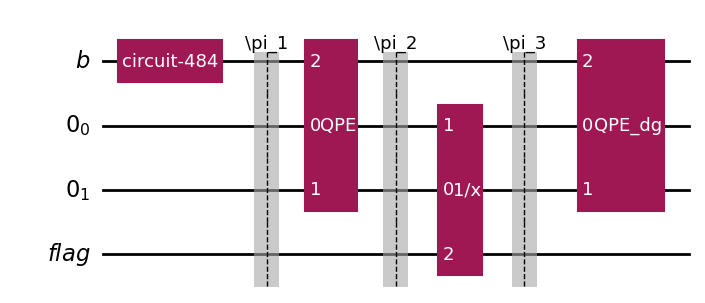

In [24]:
vector = np.array([1,1])
matrix = tridiag_matrix(2,-1,2)

hhl,scaling = build_circuit(matrix,vector,10e-2,flag=True)
hhl.draw('mpl')

# Code to print the circuit into latex code
# tes=hhl.draw('latex_source')
# f = open('aux.tex','a+')
# f.write(tes)
# f.close()

# hhl_d = hhl.decompose(reps=6)

# hhl_d.draw('mpl')


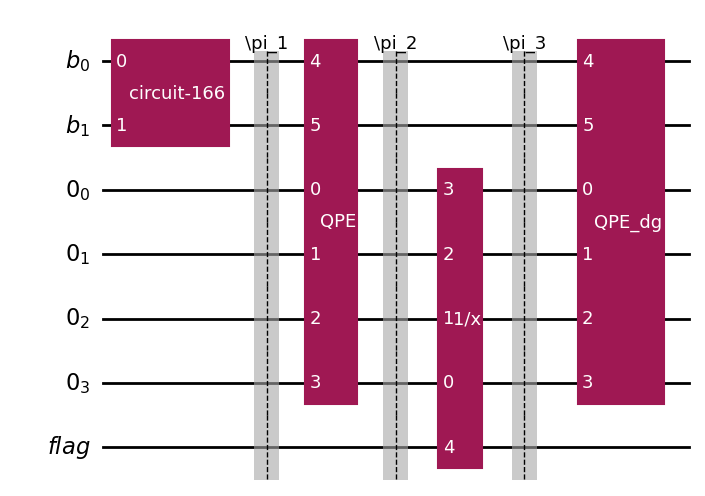

In [2]:
vector = np.array([1]*4)
matrix = tridiag_matrix(2,-1,4)
hhl,scaling = build_circuit(matrix,vector,flag=True)
hhl.decompose(reps=0).draw('mpl')

-----
We can test the circuit using statevectors

In [3]:
sol1=solution(hhl)
print(sol1)

[0.39206738 0.5884583  0.5884583  0.39206738]


Exact solution

In [4]:
sol=np.linalg.solve(matrix,vector/np.linalg.norm(vector))
sol/np.linalg.norm(sol)
norm=np.sqrt(sum(sol**2))

sol2=sol/norm
print(sol2)

[0.39223227 0.58834841 0.58834841 0.39223227]


If we have a 2-dimensional vector, the solution with statevectors is exact (we only have one qubit for $b$). But as we increase the dimension, the solution worsens

In [5]:
diff = np.abs(sol1-sol2)
print(f'The difference is: {diff}')
MSE = np.linalg.norm(diff)
print(f'The norm of the diff is: {MSE}')

The difference is: [0.00016489 0.00010989 0.00010989 0.00016489]
The norm of the diff is: 0.00028022705622520757


-----
## Simulation with shots

In [8]:
def prob_from_counts_hhl(counts,shots: int, repeat) -> np.ndarray:
    """ Calculates the expected amplitudes of the solution |x> without normalization
    
    Args:
        `counts`: Counts as a dictionary {'xxxxx': number}, obtained from a simulation or run in a real QPU
        `shots`: Number of shots (runs) of the circuit
        `repeat`: Number of qubits used to represent the right-hand side vector in the system
    Returns:
        The non normalized amplitudes of the solution. To get the real solution, you should normalize it and multiply it by the norm of the solution.
    """ 
    if not isinstance(repeat,int):
        repeat = int(repeat)
        
    all_outcomes = [''.join(outcome) for outcome in product('01', repeat=repeat)]

    # Initialize the dictionary with each binary string as a key and a value of 0
    prob_amplitudes = {outcome: 0 for outcome in all_outcomes}

    for outcome, count in counts.items():
        first_qubit_state = outcome[-repeat:]  # Get the state of the first qubit
        prob_amplitudes[first_qubit_state] += count / shots

    ampl = np.array(list(prob_amplitudes.values()))
    return ampl

Estimated amplitudes of the solution: [0.49829102 0.50170898]


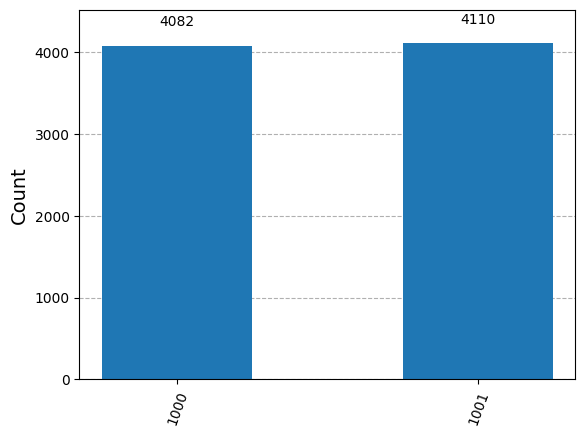

In [29]:
sim = AerSimulator()
hhl_meas,_ = build_circuit(matrix,vector,10e-4,True,True)
hhl_meas = transpile(hhl_meas,sim)

sampler = SamplerV2()

shots = 8192

job = sampler.run([hhl_meas],shots=shots)
job_result = job.result()

counts=job_result[0].data.meas.get_counts()

prob_amplitudes = prob_from_counts_hhl(counts,shots,np.log2(len(vector)))

print("Estimated amplitudes of the solution:", prob_amplitudes)

plot_histogram(job_result[0].data.meas.get_counts())

Una vez tenemos las amplitudes calculadas, podemos ver su distancia con el valor real del problema. Para poder compararlas, debemos hacer $\frac{\vec{x}}{||\vec{x}||}$, sobre el diccionario de valores

In [30]:
ampl = prob_amplitudes/np.linalg.norm(prob_amplitudes)

# Calculate the difference
diff = np.abs(ampl-sol2)
print(f'The difference is: {diff}')
MSE = np.linalg.norm(diff)
print(f'The norm of the diff is: {MSE}')

The difference is: [0.00242099 0.00241272]
The norm of the diff is: 0.003417953776192185


---

## Observables

In [41]:
# This is just a test
hhl.remove_final_measurements()
st = Statevector(hhl).data.real
st = st**2

num = int(len(st)/2)

prob = sum(st[num:])

print(prob)

0.9483449498783023


In [62]:
num = 0
for i in hhl.qregs:
    num+=i.size
num

num2 = sum(i.size for i in hhl.qregs)
num2

7

In [65]:
def norm_from_counts(counts,scaling,vector):
    filtered_counts = {k: v for k, v in counts.items() if k[0] == '1'}
    total_filtered_counts = sum(filtered_counts.values())
    norm_b = np.linalg.norm(vector)

    P1 = total_filtered_counts/shots
    norm_x = np.sqrt(P1)*norm_b/(scaling)
    return norm_x

def solution_from_qc(qc: QuantumCircuit,scaling,vector):

    qc.remove_final_measurements()
    st = Statevector(qc).data.real
    num = (2**(sum(i.size for i in qc.qregs)-1))
    prob = sum(st[num:]**2)
    st = st[num:num+len(vector)]
    norm_b = np.linalg.norm(vector)
    norm_x = np.sqrt(prob)*norm_b/scaling
    sol = norm_x*st/np.linalg.norm(st)

    return sol

||x|| = 5.095423264867581


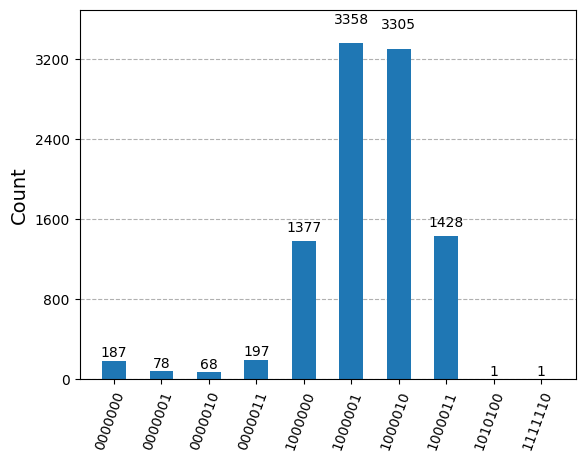

In [54]:
from qiskit_aer.primitives import SamplerV2

sim = AerSimulator()
hhl_meas = hhl
hhl.remove_final_measurements()
hhl_meas.measure_all()

hhl_meas = transpile(hhl,sim)

sampler = SamplerV2()
shots = 10000

job = sampler.run([hhl_meas],shots=shots)
job_result = job.result()
counts=job_result[0].data.meas.get_counts()

norm_x = norm_from_counts(counts,scaling,vector)

print(f'||x|| = {norm_x}')

plot_histogram(counts)

In [66]:
solution_from_qc(hhl,scaling,vector)

array([1.99916739, 3.00057257, 3.00057257, 1.99916739])

In [38]:
sol_e = np.linalg.solve(matrix,vector)
sol_e

array([2., 3., 3., 2.])

El error daba errores, así que voy a pasar de ello un poco de momento

---

## Parallelization of circuits

We are going to discuss a theoretical approach, that could be used to improve the performance of the algorithm, and that is crucial for some steps as discussed in [2], paralellization. This means, running several circuits at the same time. In a simulation, we can do this using different parallelization modules in python, like Dask. However in a real quantum computer we can have 2 different approaches :

- **Running multiple circuits in the same QPU**: We can map multiple circuits in a single topology of QPU. This is really aggresive as it creates a lot of noise that could end up losing precission. This approach wouldn't use any python package.
- **Running classical instructions needed**: Much less agressive approach. We can divide the N executions of the quantum circuits, and the classical computation that makes the hybrid approach work into N different threads (workers if we are using Dask or pools with multiprocessing).

### Parallelization of the circuit simulation

We are going to include paralellization in the `ampl_from_qmio` function, parellizing the loop of number of repetitions.

In [5]:
def ampl_from_qmio(qc,reps=1):
    sim = AerSimulator()
    qc.remove_final_measurements()
    qc.measure_all()
    qc = transpile(qc,sim)
    
    nb = qc.qregs[0].size
    nl = qc.qregs[1].size
    
    sampler = SamplerV2()
    shots = 8192
    counts = {}
    for _ in range(reps):
        job = sampler.run([qc],shots=shots)
        job_result = job.result()
        res=job_result[0].data.meas.get_counts()
        counts = {k: counts.get(k, 0) + res.get(k, 0) for k in set(res) | set(counts)}
    
    all_outcomes = [''.join(outcome) for outcome in product('01', repeat=nb+nl+1)]
    shots= shots*reps
    prob = []
    
    for elem in all_outcomes:
        if elem in counts:
            prob.append(counts[elem]/shots)
        else:
            prob.append(0)
    prob = np.array(prob)
    # prob = np.sqrt(prob)
    return prob

In [6]:
pol = [ampl_from_qmio(hhl)[64:68] for _ in range(16)]
np.sqrt(sum(pol)/16)

array([0.38216423, 0.57445786, 0.57197558, 0.3798916 ])

In [7]:
def ampl_from_qmio_par(qc,reps=1):
    sim = AerSimulator()
    qc.remove_final_measurements()
    qc.measure_all()
    qc = transpile(qc,sim)
    
    nb = qc.qregs[0].size
    nl = qc.qregs[1].size
    
    sampler = SamplerV2()
    shots = 8192
    args = [(qc,shots,sampler)]*reps
    
    with mp.Pool() as pool:
        count_list = pool.starmap(run_circuit,args)
    counts = {}
    for d in count_list:
        counts = {k: counts.get(k, 0) + d.get(k, 0) for k in set(d) | set(counts)}
    
    all_outcomes = [''.join(outcome) for outcome in product('01', repeat=nb+nl+1)]
    shots= shots*reps
    prob = []
    
    for elem in all_outcomes:
        if elem in counts:
            prob.append(counts[elem]/shots)
        else:
            prob.append(0)
    prob = np.array(prob)
    prob = np.sqrt(prob)
    return prob

In [8]:
hhl.remove_final_measurements()
sim = AerSimulator()
hhl.measure_all()
hhl = transpile(hhl,sim)
sampler = SamplerV2()
args = [(hhl,8192,sampler)]*8

pol = [run_circuit(hhl,8192,sampler) for _ in range(8)]

with mp.Pool(mp.cpu_count()) as pool:
    pol = pool.starmap(run_circuit,args)

counts = {}
for d in pol:
    counts = {k: counts.get(k, 0) + d.get(k, 0) for k in set(d) | set(counts)}
counts

{'0010101': 1,
 '1000010': 21536,
 '0000000': 1224,
 '0000010': 433,
 '1000000': 9366,
 '0011101': 1,
 '0000011': 1218,
 '1011111': 1,
 '1000011': 9668,
 '0010111': 1,
 '1000001': 21625,
 '1011110': 1,
 '0000001': 461}

In [9]:
ampl_from_qmio_par(hhl,150)

array([0.13700491, 0.0836874 , 0.08435571, 0.13693955, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.0015625 , 0.        , 0.        , 0.        ,
       0.00285272, 0.0015625 , 0.00127578, 0.00220971, 0.00090211,
       0.        , 0.        , 0.        , 0.00255155, 0.0015625 ,
       0.00201718, 0.00270633, 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.00090211, 0.        , 0.00090211,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.38216889,
       0.57233659, 0.57320897, 0.38219338, 0.        , 0.        ,
       0.        , 0.        , 0.00090211, 0.        , 0.     

By doing a little time test, we can see that the time used to start the pool is mostly higher than the workload used by them, making this approach slower for small batch sizes, that are the sizes that we need to use, so we can abandon this approach for the moment. We can, however, try to parallelize the whole function, then we can add the probabilities and divide by the repetitions. Also we can compare the time.

In [3]:
np.sqrt(prob_from_sim(hhl))

array([0.38559258, 0.57388649, 0.57164869, 0.37969072])

In [10]:
import time
start = time.time()
sol=ampl_from_qmio(hhl,20)
end = time.time()
end-start

0.9754180908203125

In [11]:
start = time.time()
sol1=ampl_from_qmio_par(hhl,20)
end = time.time()
end-start

5.111511707305908

In [12]:
start = time.time()
args = [hhl]*20
with mp.Pool(mp.cpu_count()) as pool:
    res = pool.map(prob_from_sim,args)
    
sol2 = np.sum(res)/20
end = time.time()
print(end-start)
# print(np.sqrt(sol)/np.linalg.norm(np.sqrt(sol)))

5.331140041351318


This approach doesnt work as intended. However, it now seems like the first approach was working. We'll test this in the next cell.

In [13]:
t = np.arange(1, 71, 3)
time1 = []
time2 = []
time3 = []
for i, elem in enumerate(t):
    print(f'Iteration number {i+1}, the total number of repetitions are: {elem}')
    # Normal circuit
    tmp = []
    for _ in range(5):
        start = time.time()
        prob = ampl_from_qmio(hhl,elem)
        end = time.time()
        tmp.append(end-start)
    time1.append(np.mean(tmp))
    tmp = []
    for _ in range(5):
        start = time.time()
        prob = ampl_from_qmio_par(hhl,elem)
        end = time.time()
        tmp.append(end-start)
    time2.append(np.mean(tmp))
    tmp = []
    for _ in range(5):
        start = time.time()
        args = [hhl]*elem
        with mp.Pool(mp.cpu_count()) as pool:
            res = pool.map(prob_from_sim,args)            
        sol2 = np.sum(res)/elem
        end = time.time()
        tmp.append(end-start)
    time3.append(np.mean(tmp))

Iteration number 1, the total number of repetitions are: 1
Iteration number 2, the total number of repetitions are: 4
Iteration number 3, the total number of repetitions are: 7
Iteration number 4, the total number of repetitions are: 10
Iteration number 5, the total number of repetitions are: 13
Iteration number 6, the total number of repetitions are: 16
Iteration number 7, the total number of repetitions are: 19
Iteration number 8, the total number of repetitions are: 22
Iteration number 9, the total number of repetitions are: 25
Iteration number 10, the total number of repetitions are: 28
Iteration number 11, the total number of repetitions are: 31
Iteration number 12, the total number of repetitions are: 34
Iteration number 13, the total number of repetitions are: 37
Iteration number 14, the total number of repetitions are: 40
Iteration number 15, the total number of repetitions are: 43
Iteration number 16, the total number of repetitions are: 46
Iteration number 17, the total numbe

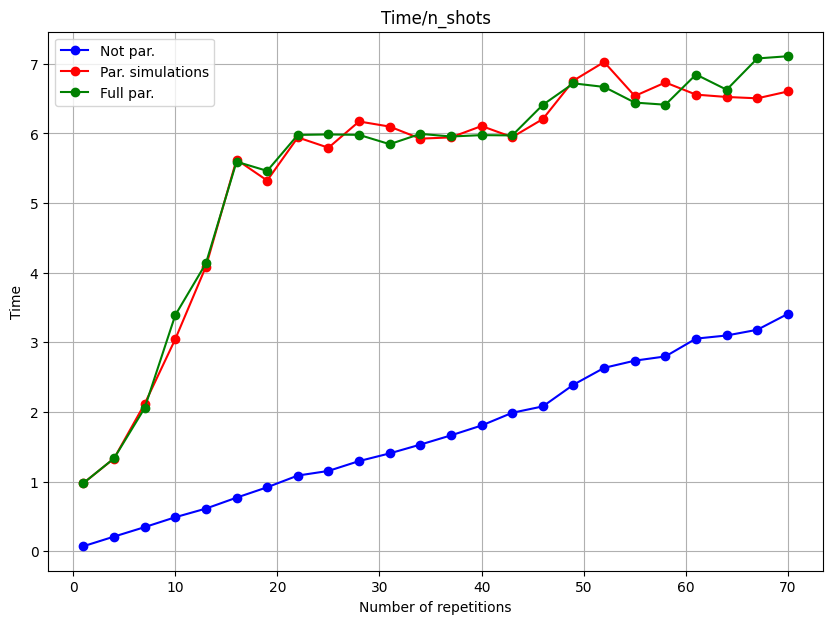

In [14]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 7))

plt.plot(t, time1, marker='o', linestyle='-', color='blue')
plt.plot(t, time2, marker='o', linestyle='-', color='red')
plt.plot(t, time3, marker='o', linestyle='-', color='green')
plt.xlabel('Number of repetitions')
plt.ylabel('Time')
plt.title('Time/n_shots')
plt.legend(['Not par.','Par. simulations','Full par.'])
plt.grid(True)
plt.show()

### Parallelization inside the circuit

We're going to define a new circuit, that includes multiple circuits in it

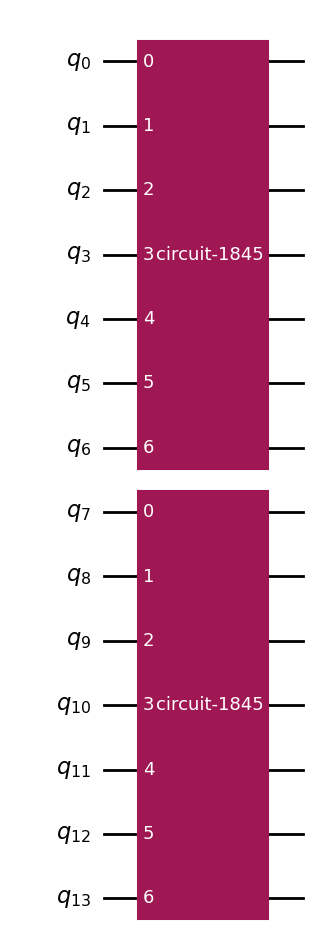

In [30]:
vector = np.array([1]*4)
matrix = tridiag_matrix(2,-1,4)
hhl,_ = build_circuit(matrix,vector)
size = 0
for reg in hhl.qregs:
    size+=reg.size
qc = QuantumCircuit(2*size)
qc.append(hhl,range(size))
qc.append(hhl,range(size,2*size))
qc.draw('mpl')

In [31]:
st = Statevector(qc).data.real
print(len(st))
print(st[64:64+4]/np.linalg.norm(st[64:64+4]))
sol2 = [st[8192],st[8320],st[8448],st[8576]]
print(sol2/np.linalg.norm(sol2))

16384
[0.39206738 0.5884583  0.5884583  0.39206738]
[0.39206738 0.5884583  0.5884583  0.39206738]


In [35]:
sim = AerSimulator()
qc.measure_all()
qc = transpile(qc,sim)
sampler = SamplerV2()
shots = 8192
job = sampler.run([qc],shots=shots)
job_result = job.result()
counts=job_result[0].data.meas.get_counts()

all_outcomes = [''.join(outcome) for outcome in product('01', repeat=2*size)]

prob = []
for elem in all_outcomes:
    if elem in counts:
        prob.append(counts[elem]/shots)
    else:
        prob.append(0)
prob = np.array(prob)
prob = np.sqrt(prob)
prob

array([0.0292317, 0.       , 0.015625 , ..., 0.       , 0.       ,
       0.       ])

In [36]:
print(prob[64:64+4]/np.linalg.norm(prob[64:64+4]))
prob2 = [prob[8192],prob[8320],prob[8448],prob[8576]]
print(prob2/np.linalg.norm(prob2))

[0.37169597 0.60153313 0.56777497 0.42146362]
[0.43452409 0.58536941 0.57936546 0.36450944]


This approach seems to work, but it is necessary to test it in real hardware